# Uplift Моделирование

## Представим задачу

Необходимо совершить коммуникацию с пользователями и сделать им некоторое предложение (например, предложение о подписке на очень выгодных условиях).
При этом мы понимаем, что:
1. не всем пользователям это интересно
2. за коммуникацию мы платим деньги
3. нам нужно как-то еще умудриться определить тех, кто и без коммуникации совершил бы нужное нам действие

Как действовать?
Представим, что у нас в базе есть данные о пользователях, которые уже приобретали подписки ранее без всякого воздействия. Мы уже умеем решать LookAlike! Но это даст нам вероятность P(y=1|x). Мы же хотим действовать более точечно. 

По реакции на коммуникацию всех клиентов можно разделить на 4 категории:

<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/client_types_RU.png" alt="Категории клиентов"/>
</p>

(Источник: https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/client_types_RU.png)

1. **`Спящая собака`** - человек, который будет реагировать негативно, если с ним прокоммуницировать. Яркий пример: клиенты, которые забыли про платную подписку. Получив напоминание об этом, они обязательно ее отключат. Но если их не трогать, то клиенты по-прежнему будут приносить деньги. В терминах математики: $W_i = 1, Y_i = 0$ или $W_i = 0, Y_i = 1$.
2. **`Потерянный`** - человек, который не совершит целевое действие независимо от коммуникаций. Взаимодействие с такими клиентами не приносит дополнительного дохода, но создает дополнительные затраты. В терминах математики: $W_i = 1, Y_i = 0$ или $W_i = 0, Y_i = 0$.
3. **`Лояльный`** - человек, который будет реагировать положительно, несмотря ни на что - самый лояльный вид клиентов. По аналогии с предыдущим пунктом, такие клиенты также расходуют ресурсы. Однако в данном случае расходы гораздо больше, так как **лояльные** еще и пользуются маркетинговым предложением (скидками, купонами и другое). В терминах математики: $W_i = 1, Y_i = 1$ или $W_i = 0, Y_i = 1$.
4. **`Убеждаемый`** - это человек, который положительно реагирует на предложение, но при его отсутствии не выполнил бы целевого действия. Это те люди, которых мы хотели бы определить нашей моделью, чтобы с ними прокоммуницировать. В терминах математики: $W_i = 0, Y_i = 0$ или $W_i = 1, Y_i = 1$.

Таким образом, в данной задаче нам хочется не просто спрогнозировать вероятность выполнения целевого действия, а сосредоточить рекламный бюджет на клиентах, которые выполнят целевое действие только при нашем взаимодействии. Иначе говоря, для каждого клиента хочется отдельно оценить две условные вероятности:

* Выполнение целевого действия при нашем воздействии на клиента. 
    Таких клиентов будем относить к **тестовой группе (aka treatment)**: $P^T = P(Y=1 | W = 1)$,
* Выполнение целевого действия без воздействия на клиента. 
    Таких клиентов будем относить к **контрольной группе (aka control)**: $P^C = P(Y=1 | W = 0)$,

где $Y$ - бинарный флаг выполнения целевого действия, $W$ - бинарный флаг наличия коммуникации (в англоязычной литературе - _treatment_)

Сам же причинно-следственный эффект **называется uplift** и оценивается как разность двух этих вероятностей:

$$ uplift = P^T - P^C = P(Y = 1 | W = 1) - P(Y = 1 | W = 0)$$

Нам нужно оценить разницу между двумя событиями, которые являются взаимоисключающими для конкретного клиента (либо мы взаимодействуем с человеком, либо нет; нельзя одновременно совершить оба этих действия). 

Для получения обучающей выборки для моделирования uplift необходимо провести эксперимент: 
1. Случайным образом разбить часть пользователей на тестовую и контрольную выборки
2. Провести коммуникацию только с тестовой группой

Данные, полученные в рамках эксперимента, позволят нам в дальнейшем построить модель uplift.

Подходы к моделированию uplift можно разделить на два класса:
1. с применением одной моделью
2. с применением двух моделей

Использовать будем [данные конкурса RetailHero.ai](https://retailhero.ai/c/uplift_modeling/overview):

### Импорт библиотек и чтение данных

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
#import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df_clients = pd.read_csv('./data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./data/uplift_test.csv', index_col='client_id')

In [2]:
from sklearn.metrics import roc_auc_score, f1_score, log_loss

In [3]:
holidays = []
for i in np.arange(2010, 2021, 1):
    holidays.append(str(i)+'-12-30')
    holidays.append(str(i)+'-12-31')
    holidays.append(str(i)+'-01-01')
    holidays.append(str(i)+'-01-02')
    holidays.append(str(i)+'-02-22')
    holidays.append(str(i)+'-02-23')
    holidays.append(str(i)+'-03-06')
    holidays.append(str(i)+'-03-07')
    holidays.append(str(i)+'-03-08')

In [4]:
df_clients['first_issue_date'] = pd.to_datetime(df_clients['first_issue_date'])
df_clients['first_redeem_date'] = pd.to_datetime(df_clients['first_redeem_date'])

In [5]:
df_clients['is_holiday_issue'] = 'no'
df_clients['is_holiday_issue'].loc[df_clients['first_redeem_date'].dt.floor('d').isin(holidays)] = 'yes'

df_clients['is_holiday_redeem'] = 'no'
df_clients['is_holiday_redeem'].loc[df_clients['first_redeem_date'].dt.floor('d').isin(holidays)] = 'yes'

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<div class="alert alert-block alert-success">
    <p> 
       Попытка добавить категории по принципу "покупка в праздничный день" или "время суток покупки" только снизили качество модели
    </p>
</div>

In [6]:
df_clients['time_of_day'] = 'night'

In [7]:
df_clients['time_of_day'].loc[(df_clients['first_redeem_date'].dt.hour) <= 12 &
                             (df_clients['first_redeem_date'].dt.hour > 6)] = 'morning'

df_clients['time_of_day'].loc[(df_clients['first_redeem_date'].dt.hour <= 18) &
                             (df_clients['first_redeem_date'].dt.hour >12)] = 'afternoon'
                              
df_clients['time_of_day'].loc[(df_clients['first_redeem_date'].dt.hour <= 24) &
                             (df_clients['first_redeem_date'].dt.hour > 18)] = 'evening'

In [8]:
# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

In [9]:
df_clients['age'].describe()

count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

In [10]:
df_clients['gender'].value_counts()

U    185706
F    147649
M     66807
Name: gender, dtype: int64

In [11]:
df_features.loc[df_features['age'] < 0, 'age'] = 0

In [12]:
df_features.loc[df_features['age'] > 90, 'age'] = df_features['age'].median()

In [13]:
def age_cat(data) :
    
    if data["age"] <= 21 :
        return "age_0-21"
    elif (data["age"] > 21) & (data["age"] <= 35 ):
        return "age_21-35"
    elif (data["age"] > 35) & (data["age"] <= 50) :
        return "age_35-50"
    elif (data["age"] > 50) & (data["age"] <= 65) :
        return "age_50-65"
    elif data["age"] > 65 :
        return "age_gt_65"
    
df_features["age_group"] = df_features.apply(lambda df_features:age_cat(df_features),
                                      axis = 1)

In [14]:
df_features.drop(['age'], axis=1, inplace=True)

In [15]:
#признаки
df_features

,gender,is_holiday_issue,is_holiday_redeem,time_of_day,first_issue_time,first_redeem_time,issue_redeem_delay,age_group
client_id,,,,,,,,
000012768d,U,no,no,evening,1501947648,1.515094e+09,13146559.0,age_35-50
000036f903,F,no,no,night,1491832463,1.492951e+09,1118613.0,age_gt_65
000048b7a6,F,no,no,night,1544880791,NaN,NaN,age_gt_65
000073194a,F,no,no,night,1495544174,1.511522e+09,15978107.0,age_50-65
00007c7133,U,yes,yes,afternoon,1495469828,1.546277e+09,50806825.0,age_gt_65
00007f9014,F,no,no,evening,1503408901,1.550258e+09,46849457.0,age_35-50
0000a90cf7,U,no,no,night,1495283690,1.499518e+09,4234412.0,age_35-50
0000b59cec,U,no,no,afternoon,1497002660,1.514400e+09,17397098.0,age_35-50
0000bb4e4e,M,no,no,afternoon,1494345727,1.503681e+09,9334854.0,age_35-50


Посмотрим, что же у нас за данные

In [16]:
df_train.head(3)

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1


In [17]:
df_train.groupby('treatment_flg')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


In [18]:
df_train['target'].value_counts()

1    124002
0     76037
Name: target, dtype: int64

Поле treatment_flg - было воздействие или нет.

Для удобства объявим некоторые переменные:

In [19]:
# cat_features = ['gender', 'age_group', 'is_holiday_issue', 'is_holiday_redeem', 'time_of_day']
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for i in cat_features :
#     df_features[i] = le.fit_transform(df_features[i])

In [20]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender', 'age_group', 'is_holiday_issue', 'is_holiday_redeem', 'time_of_day']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift_auc_score': []
}

## 1. Подходы с одной моделью

### 1.1 Одна модель с признаком коммуникации

Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.


<p align="center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/SoloModel_RU.png" alt="Solo model with treatment as a feature"/>
</p>

<div class="alert alert-block alert-success">
    <p> 
        Изменили кол-во итераций, скорость обучения и макс. глубину.
    </p>
</div>

In [21]:
sklift.metrics.uplift_at_k?

Object `sklift.metrics.uplift_at_k` not found.


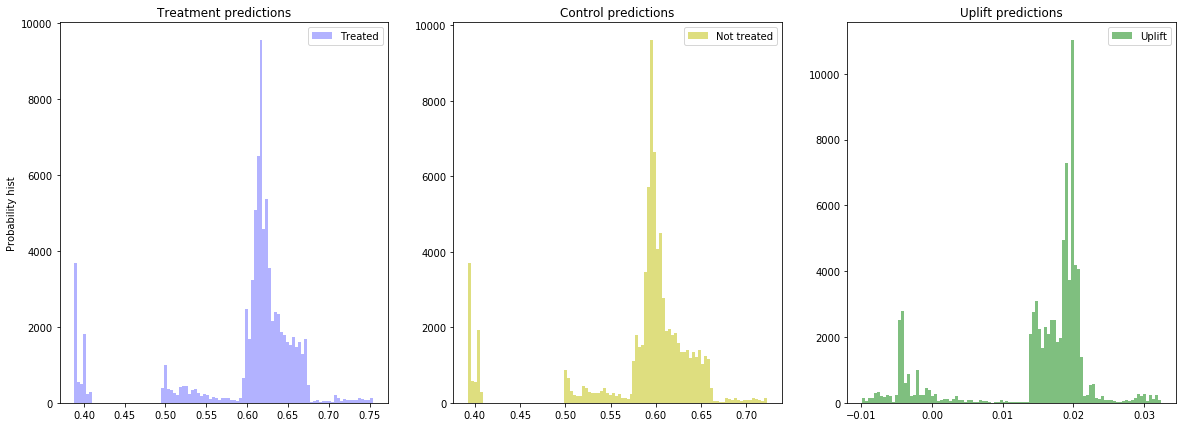

In [22]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k, uplift_auc_score
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=150, max_depth=5, learning_rate=0.01 ,thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_auc = uplift_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)
models_results['uplift_auc_score'].append(sm_auc)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [23]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,58.040759
1,issue_redeem_delay,33.611987
2,first_issue_time,5.245341
3,treatment,2.960593
4,is_holiday_redeem,0.098321
5,is_holiday_issue,0.043000
6,gender,0.000000
7,time_of_day,0.000000
8,age_group,0.000000


In [24]:
#посмотрим на models_results
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift_auc_score
0,SoloModel,0.063078,0.021963


### 1.2 Трансформация классов

Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

$$
Z_i = Y_i \cdot W_i + (1 - Y_i) \cdot (1 - W_i),
$$
где 

* $Z_i$ - новая целевая переменная $i$-ого клиента; 
* $Y_i$ - целевая перемнная $i$-ого клиента;
* $W_i$ - флаг коммуникации $i$-ого клиента;  


Другими словами, новый класс равен 1, если мы знаем, что на конкретном наблюдении, результат при взаимодействии был бы таким же хорошим, как и в контрольной группе, если бы мы могли знать результат в обеих группах:

$$
Z_i = \begin{cases}
    1, & \mbox{if } W_i = 1 \mbox{ and } Y_i = 1 \\
    1, & \mbox{if } W_i = 0 \mbox{ and } Y_i = 0 \\
    0, & \mbox{otherwise}
   \end{cases}
$$

Распишем подробнее, чему равна вероятность новой целевой переменной:

$$ 
P(Z=1|X = x) = \\
= P(Z=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Z=1|X = x, W = 0) \cdot P(W = 0|X = x) = \\
= P(Y=1|X = x, W = 1) \cdot P(W = 1|X = x) + \\
+ P(Y=0|X = x, W = 0) \cdot P(W = 0|X = x).
$$

Выше мы обсуждали, что обучающая выборка для моделирования uplift собирается на основе рандомизированного разбиения части клиенской базы на тестовую и контрольную группы. Поэтому коммуникация $ W $ не может зависить от признаков клиента $ X_1, ..., X_m $. Принимая это, мы имеем: $ P(W | X_1, ..., X_m, ) = P(W) $ и 

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot P(W = 1) + \\
+ P^C(Y=0|X = x) \cdot P(W = 0)
$$

Также допустим, что $P(W = 1) = P(W = 0) = \frac{1}{2}$, т.е. во время эксперимента контрольные и тестовые группы были разделены в равных пропорциях. Тогда получим следующее:

$$
P(Z=1|X = x) = \\
= P^T(Y=1|X = x) \cdot \frac{1}{2} + P^C(Y=0|X = x) \cdot \frac{1}{2} \Rightarrow \\
2 \cdot P(Z=1|X = x) = \\
= P^T(Y=1|X = x) + P^C(Y=0|X = x) = \\
= P^T(Y=1|X = x) + 1 - P^C(Y=1|X = x) \Rightarrow \\
\Rightarrow P^T(Y=1|X = x) - P^C(Y=1|X = x) = \\
 = uplift = 2 \cdot P(Z=1|X = x) - 1
$$

Таким образом, увеличив вдвое прогноз нового таргета и вычтя из него единицу мы получим значение самого uplift'a, т.е.

$$
uplift = 2 \cdot P(Z=1) - 1
$$

Исходя из допущения описанного выше: $P(W = 1) = P(W = 0) = \frac{1}{2}$, данный подход следует использовать только в случаях, когда количество клиентов, с которыми мы прокоммуницировлаи, равно количеству клиентов, с которыми коммуникации не было. 

In [25]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_auc = uplift_auc_score(y_true=y_val, uplift=uplift_ct, treatment=treat_val)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)
models_results['uplift_auc_score'].append(ct_auc)


C:\Users\Pavel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


## 2. Подходы с двумя моделями

Подход с двумя моделями можно встретить почти в любой работе по uplift моделированию, он часто используется в качестве бейзлайна. Однако использование двух моделей может привести к некоторым неприятным последствиям: если для обучения будут использоваться принципиально разные модели или природа данных тестовой и контрольной групп будут сильно отличаться, то возвращаемые моделями скоры  будут не сопоставимы между собой. Вследствие чего расчет uplift будет не совсем корректным. Для избежания такого эффекта необходимо калибровать модели, чтобы их скоры можно было интерпертировать как вероятности. Калибровка вероятностей модели отлично описана в [документации scikit-learn](https://scikit-learn.org/stable/modules/calibration.html).

### 2.1 Две независимые модели

Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_vanila_RU.png" alt="Two Models vanila"/>
</p>

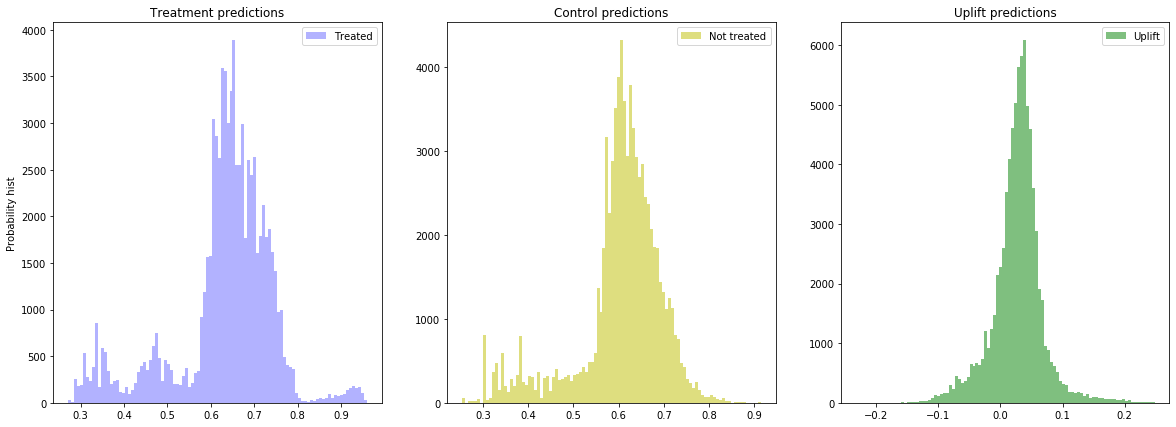

In [26]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
tm_auc = uplift_auc_score(y_true=y_val, uplift=uplift_tm, treatment=treat_val)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)
models_results['uplift_auc_score'].append(tm_auc)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 2.2 Две зависимые модели

Подход зависимого представления данных основан на методе цепочек классификаторов, первоначально разработанном для задач многоклассовой классификации. Идея состоит в том, что при наличии $L$ различных меток можно построить $L$ различных классификаторов, каждый из которых решает задачу бинарной классификации и в процессе обучения каждый следующий классификатор использует предсказания предыдущих в качестве дополнительных признаков. Авторы данного метода предложили использовать ту же идею для решения проблемы uplift моделирования в два этапа. В начале мы обучаем классификатор по контрольным данным: 
$$
P^C = P(Y=1| X, W = 0),
$$
затем исполним предсказания $P_C$ в качестве нового признака для обучения второго классификатора на тестовых данных, тем самым эффективно вводя зависимость между двумя наборами данных:

$$
P^T =  P(Y=1| X, P_C(X), W = 1)
$$

Чтобы получить uplift для каждого наблюдения, вычислим разницу:

$$
uplift(x_i) = P^T(x_i, P_C(x_i)) - P^C(x_i)
$$

Интуитивно второй классификатор изучает разницу между ожидаемым результатом в тесте и контроле, т.е. сам uplift.

<p align= "center">
  <img src="https://raw.githubusercontent.com/maks-sh/scikit-uplift/master/docs/_static/images/TwoModels_ddr_control_RU.png" alt="Two dependent models"/>
</p>

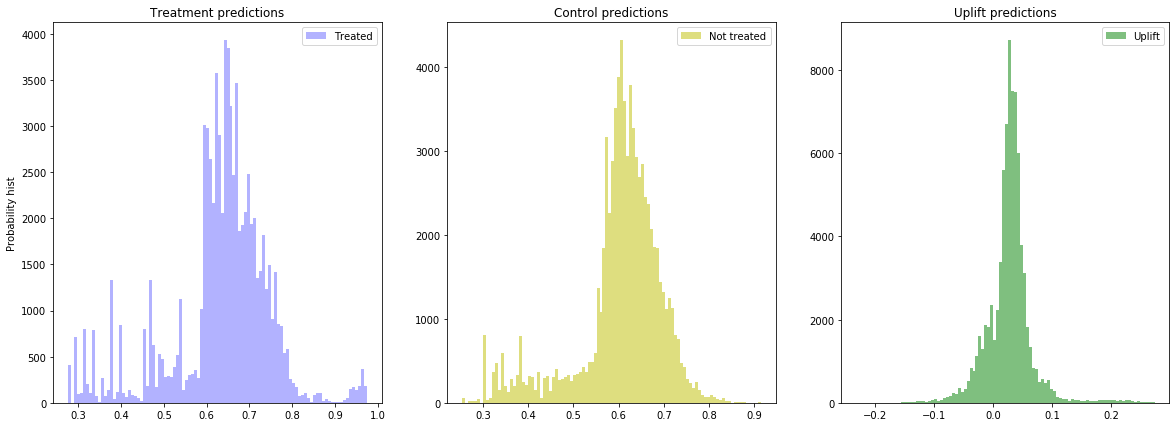

In [27]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)
tm_ctrl_auc = uplift_auc_score(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)
models_results['uplift_auc_score'].append(tm_ctrl_auc)


plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

Аналогичным образом можно сначала обучить классификатор $P^T$, а затем использовать его предсказания в качестве признака для классификатора $P^C$.

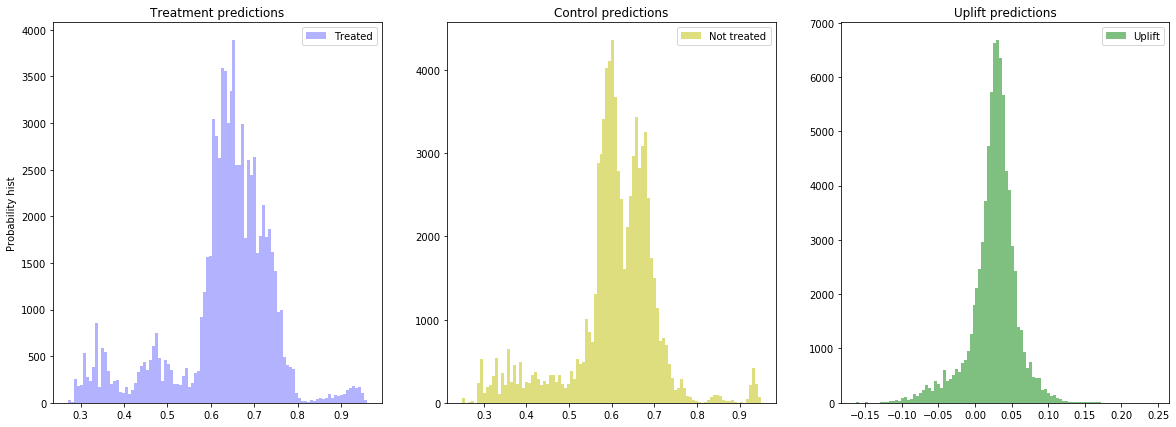

In [28]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)
tm_trmnt_auc = uplift_auc_score(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)
models_results['uplift_auc_score'].append(tm_trmnt_auc)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

In [29]:
pd.DataFrame({
    'feature_name': tm_trmnt.estimator_ctrl.feature_names_,
    'feature_score': tm_trmnt.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,ddr_treatment,59.206859
1,issue_redeem_delay,13.149727
2,first_issue_time,10.676026
3,first_redeem_time,7.508502
4,gender,4.028225
5,time_of_day,1.941467
6,age_group,1.740015
7,is_holiday_issue,1.209630
8,is_holiday_redeem,0.539549


In [30]:
pd.DataFrame({
    'feature_name': tm_trmnt.estimator_trmnt.feature_names_,
    'feature_score': tm_trmnt.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,first_redeem_time,47.660230
1,issue_redeem_delay,34.472110
2,age_group,8.523836
3,first_issue_time,6.624942
4,gender,2.366836
5,is_holiday_issue,0.352046
6,is_holiday_redeem,0.000000
7,time_of_day,0.000000


## Выводы

Рассмотрим, какой метод лучше всего показал себя в этой задаче

<div class="alert alert-block alert-success">
    <p> 
        Минимальный подбор параметров для Solomodel вывел её в лидеры
    </p>
</div>

In [31]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift_auc_score
0,SoloModel,0.063078,0.021963
2,TwoModels,0.059825,0.023302
1,ClassTransformation,0.058502,0.024143
3,TwoModels_ddr_control,0.051909,0.016493
4,TwoModels_ddr_treatment,0.037088,0.016493


Из таблички выше можно понять, что в текущей задаче лучше всего справился подход трансформации целевой перемнной. Обучим модель на всей выборке и предскажем на тест.

<div class="alert alert-block alert-danger">
    <p> 
        Не совсем понял, почему в задании указаны метрики (roc auc, logloss, f1). Наша модель предсказывает вероятности, и для её оценки используются другие метрики. Перечисленные в задании подходят для бинарной классификации. 
    </p>
</div>

### Домашнее задание (часть 2)

1. Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering
2. Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже). 
3. Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на model.estimator.feature_importances_ и model.estimator.feature_names_. 
4. Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе


Дополнительно (полезные ссылки):
1. доклад о персональных сообщениях (рассылке) - https://www.youtube.com/watch?v=UNegf9Rgpnw
2. http://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf
3. доклад от Ирины Елисовой (МТС) - https://youtu.be/jCUcYiBK03I
4. https://arxiv.org/pdf/1809.04559.pdf